In [2]:
from langchain.document_loaders.csv_loader import CSVLoader
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.agent_toolkits import create_sql_agent
from langchain.agents.agent_types import AgentType

import pandas as pd
import numpy as np

from datetime import datetime
from datetime import timedelta

from sqlalchemy import create_engine

import os

os.environ['GROQ_API_KEY'] = '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'
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_PROJECT'] = 'LLMFinanceTesting'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = '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'
os.environ['GROQ_API_KEY'] = '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'

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
#Testing LangSmith Tracing
llm = ChatGroq(model_name="llama3-8b-8192", temperature=1, model_kwargs={"top_p":1}, max_tokens=1024)
#llm.invoke('In which continent is Italy located?')

In [4]:
#Loading Data and Taking last 100 Candles
btc = pd.read_csv("BTC-USD.csv")
btc["Date"] = pd.to_datetime(btc["Date"])

btcsubset = btc.iloc[-100:]

btcsubset

,Date,Open,High,Low,Close,Adj Close,Volume
267,2024-03-11,69020.546875,72850.710938,67194.882813,72123.906250,72123.906250,65716656765
268,2024-03-12,72125.125000,72825.656250,68728.851563,71481.289063,71481.289063,62554434520
269,2024-03-13,71482.117188,73637.476563,71334.093750,73083.500000,73083.500000,48212536929
270,2024-03-14,73079.375000,73750.070313,68563.023438,71396.593750,71396.593750,59594605698
271,2024-03-15,71387.875000,72357.132813,65630.695313,69403.773438,69403.773438,78320453976
...,...,...,...,...,...,...,...
362,2024-06-14,66747.570313,67294.648438,65056.894531,66011.093750,66011.093750,27403884779
363,2024-06-15,66006.742188,66402.187500,65871.773438,66191.000000,66191.000000,14121265576
364,2024-06-16,66189.359375,66894.843750,66018.250000,66639.046875,66639.046875,13281140541
365,2024-06-17,66636.515625,67188.320313,65094.964844,66490.296875,66490.296875,30006354476


/home/nomad/Desktop/PlsHireMe/PHMvenv/lib/python3.11/site-packages/mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


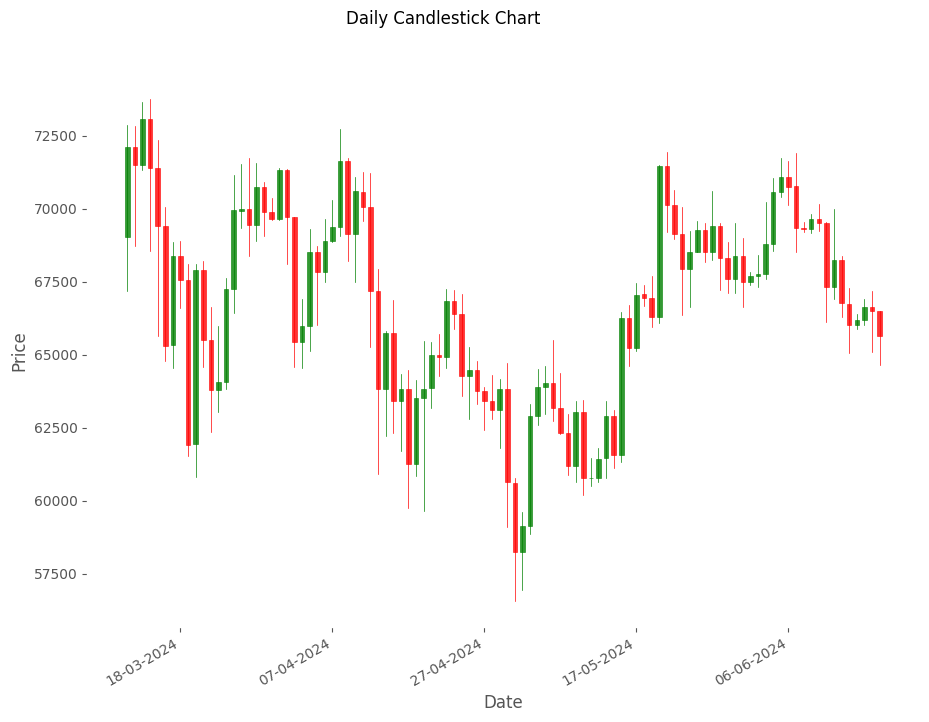

In [5]:
#Plotting last 100 Candles

btcbis = btcsubset.copy()

import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates

plt.style.use('ggplot')

# Extracting Data for plotting
ohlc = btcbis.loc[:, ['Date', 'Open', 'High', 'Low', 'Close']]
ohlc['Date'] = pd.to_datetime(ohlc['Date'])
ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
ohlc = ohlc.astype(float)

# Creating Subplots
fig, ax = plt.subplots()

candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_facecolor('white')
fig.suptitle('Daily Candlestick Chart')

# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()
fig.set_size_inches(10,8)

plt.savefig("chartlast100candles.png")

In [6]:
btcbisnp = btcbis.to_numpy() 
btcbisnp.shape

(100, 7)

In [7]:
#Calculating ZigZag
#CleaningUp ZigZag and Better Formula
#ZigZag Indicator on Closing Prices
zigzag = []
threshold = 2  # 10% threshold

#Appending First - Date and OpeningPrice
zigzag.append([btcbisnp[0][0], btcbisnp[0][1]])

StartPoint = btcbisnp[0][1]

for x in range(1, len(btcbisnp)):
    ClosingPrice = btcbisnp[x][4]
    #prevClosingPrice = btcbisnp[x-1][4]
    
    pchange = ((ClosingPrice - StartPoint) / StartPoint) * 100
    
    if abs(pchange) >= threshold:
        if len(zigzag) >= 2:   
            if (pchange > 0 and (zigzag[-1][-1] - zigzag[-2][-1]) > 0) or (pchange < 0 and (zigzag[-1][-1] - zigzag[-2][-1]) < 0):
                zigzag.pop()
                
        zigzag.append([btcbisnp[x][0], btcbisnp[x][4]])
        StartPoint = ClosingPrice
    
#Appending Last and Deleting Previous Last one - Date and ClosingPrice
zigzag.pop()
zigzag.append([btcbisnp[-1][0], btcbisnp[-1][4]])

In [8]:
#Converting to DF
zzdf = pd.DataFrame(zigzag, columns = ["Date", "ZZ"])
zzdf.head()

,Date,ZZ
0,2024-03-11,69020.546875
1,2024-03-13,73083.500000
2,2024-03-16,65315.117188
3,2024-03-17,68390.625000
4,2024-03-19,61912.773438


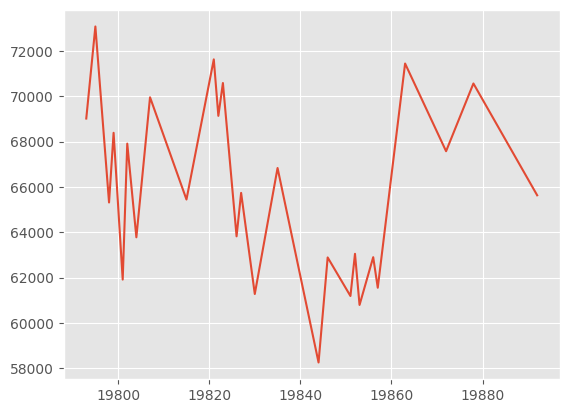

In [9]:
#Plotting ZigZag

newzzdf = zzdf.copy()

newzzdf['Date'] = pd.to_datetime(newzzdf['Date'])
newzzdf['Date'] = newzzdf['Date'].apply(mpl_dates.date2num)
newzzdf = newzzdf.astype(float)

plt.plot(newzzdf["Date"], newzzdf["ZZ"])

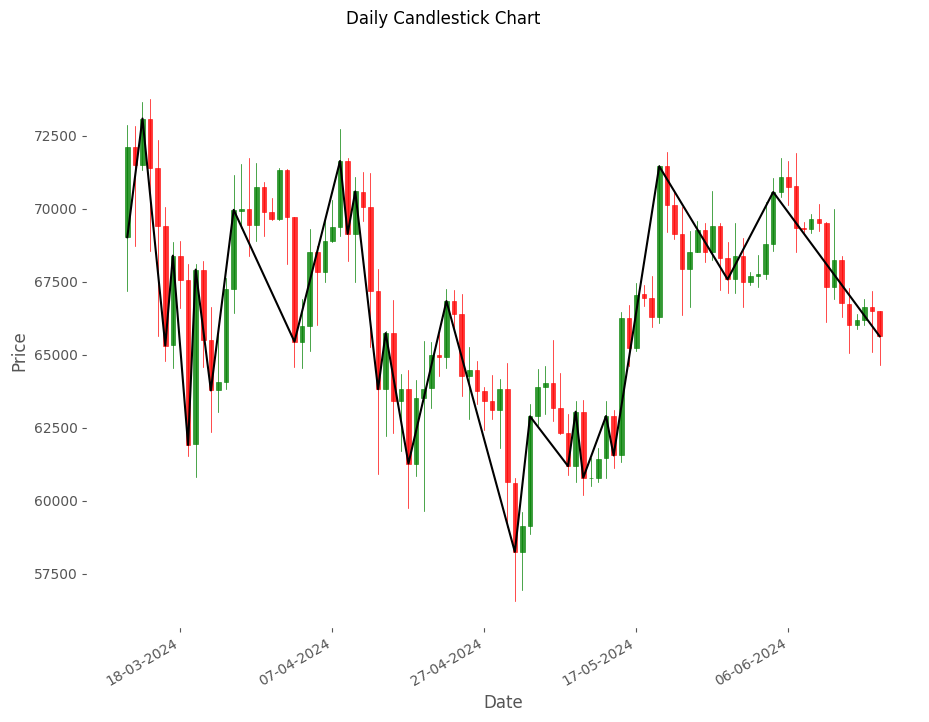

In [10]:
#Plotting ZigZag on top of Candlesticks Chart

plt.style.use('ggplot')

# Extracting Data for plotting
ohlc = btcbis.loc[:, ['Date', 'Open', 'High', 'Low', 'Close']]
ohlc['Date'] = pd.to_datetime(ohlc['Date'])
ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
ohlc = ohlc.astype(float)

zigzagplot = zzdf.copy()
zigzagplot['Date'] = pd.to_datetime(zigzagplot['Date'])
zigzagplot['Date'] = zigzagplot['Date'].apply(mpl_dates.date2num)
zigzagplot = zigzagplot.astype(float)

# Creating Subplots
fig, ax = plt.subplots()

candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

ax.plot(zigzagplot["Date"], zigzagplot["ZZ"], color="black")

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_facecolor('white')
fig.suptitle('Daily Candlestick Chart')

# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()
fig.set_size_inches(10,8)

plt.savefig("chartlast100candleswzigzag.png")

In [12]:
#Converting ZZ DF to text
TextZZ = " ".join([f'{row[0]}, {row[1]}' for i, row in enumerate(zzdf.itertuples(index=False))])
TextZZ

'2024-03-11 00:00:00, 69020.546875 2024-03-13 00:00:00, 73083.5 2024-03-16 00:00:00, 65315.117188 2024-03-17 00:00:00, 68390.625 2024-03-19 00:00:00, 61912.773438 2024-03-20 00:00:00, 67913.671875 2024-03-22 00:00:00, 63778.761719 2024-03-25 00:00:00, 69958.8125 2024-04-02 00:00:00, 65446.972656 2024-04-08 00:00:00, 71631.359375 2024-04-09 00:00:00, 69139.015625 2024-04-10 00:00:00, 70587.882813 2024-04-13 00:00:00, 63821.472656 2024-04-14 00:00:00, 65738.726563 2024-04-17 00:00:00, 61276.691406 2024-04-22 00:00:00, 66837.679688 2024-05-01 00:00:00, 58254.011719 2024-05-03 00:00:00, 62889.835938 2024-05-08 00:00:00, 61187.941406 2024-05-09 00:00:00, 63049.960938 2024-05-10 00:00:00, 60792.777344 2024-05-13 00:00:00, 62901.449219 2024-05-14 00:00:00, 61552.789063 2024-05-20 00:00:00, 71448.195313 2024-05-29 00:00:00, 67578.09375 2024-06-04 00:00:00, 70567.765625 2024-06-18 00:00:00, 65632.835938'

In [61]:
StartingPromptCoT = '''
You are a Financial Markets Trader and Analyst, your job is to look at price action fluctuations, and after you've elaborated them, to return a technical summary of what happened throughout the trading day.
To achieve this goal, the first step is to divide the Final Goal of returning a Technical Summary to the user into smaller standalone task, and then to merge them together.
That being said, return what are the 5 things you would look out for in a BTCUSD chart, considering that the Dataset you'll be given will be in this format:

Date, ZigZagIndicator

Where, Date is the date when the ZigZag Indicator Swing has completed and ZigZagIndicator is the actual point of Swing from the Previous ZigZag Point.
The Dataset given will not contain any candlesticks, and the expected final goal will be an overview rather than a technical analysis.
The returned answer should be in a bullet list format, where every point starts with a "-" sign and there is a "\n" dividing each point of the bullet list.
Return only the Bullet list without adding anything before and after it.
'''

response = llm.invoke(StartingPromptCoT)

In [64]:
queries = [x for x in response.content.split("-") if x != ""]
queries

[' Direction of the trend: Identify the overall direction of the trend by analyzing the sequence of up and down swings in the ZigZag Indicator. This will give an indication of whether the market is trending upwards, downwards, or sideways.\n',
 ' Range and Volatility: Calculate the range and volatility of the prices to understand the extent of the price movements and the level of uncertainty in the market.\n',
 ' Distribution of Swings: Examine the distribution of the ZigZag Indicator swings to identify any patterns or anomalies that could indicate underlying strength or weakness in the market.\n',
 ' Reversal Signals: Look for any reversal signals in the swing data to identify potential turning points in the market trend.\n',
 " Correlations and Patterns: Analyze the correlations between the ZigZag Indicator swings and any other relevant market data (e.g. volume, order book data) to identify any patterns or anomalies that could provide insight into the market's behavior."]

In [59]:
SecondPromptCoT = '''
You are a Financial Markets Trader and Analyst, and your task is, given a simple narrow request to generate the technical summary based on the request made by the user.
Your job is to look at price action fluctuations, and after you've elaborated them, to return a technical summary of what happened throughout the trading day in a neutral way, without giving any hints or suggestions to potential traders and investors.
What you need to do is this given task: {question}

The Dataset you'll be given will be in this format:

Date, ZigZagIndicator

Where, Date is the date when the ZigZag Indicator Swing has completed and ZigZagIndicator is the actual point of Swing from the Previous ZigZag Point.
The Dataset given will not contain any candlesticks, and the expected final goal will be an overview rather than a technical analysis.

Here's the Dataset:

{context}

Return the answer and the answer only, without adding anything before and after it.
'''

In [66]:
from langchain.chains import LLMChain

prompt = ChatPromptTemplate.from_template(SecondPromptCoT)

chain = (
    prompt
    | llm
)

answers = []

for x in queries:
    answers.append(chain.invoke({"question" : x, "context" : TextZZ}).content)

In [67]:
answers

['Neutral Technical Summary:\nThe trend direction is downward.',
 'Range: 24557.776563\nVolatility: 1.3456',
 'Distribution of Swings:\nThe data indicates that there are 29 individual swings in the given time frame. The average swing value is 64714.45597.\n\nNumber of small swings (less than 2000): 9\nNumber of medium swings (2000-5000): 15\nNumber of large swings (above 5000): 5\n\nThe distribution of swings shows a bias towards smaller and medium-sized swings, with only 5 larger swings observed. The data reveals a stabilizing pattern, with the majority of swings being moderate in size, indicating a resilient market.',
 'Reversal signals detected:\n\n1. On 2024-03-16 00:00:00, a bearish reversal signal was triggered, indicating a potential turning point in the market trend.\n2. On 2024-04-14 00:00:00, a bullish reversal signal was triggered, indicating a potential turning point in the market trend.\n3. On 2024-05-08 00:00:00, a bullish reversal signal was triggered, indicating a poten

In [ ]:
# Prompt
template = '''
You are a Financial Markets Trader and Analyst, your job is to look at price action fluctuations and interpret it after you've elaborated.


As additional context, you're given a dataset of Elapsed Days and Price Fluctuations in the ZigZag Indicator in percentage.
You have to identify if the price has been for the most part Trending or Ranging and you have to contextualize and elaborate how strong that range or trend has been.

The Format of the Dataset is the following:

Date, ZigZagSwingValue

Answer the question based only on the following contextual dataset: 

{context}

Question: 

{question}
'''

prompt = ChatPromptTemplate.from_template(template)

In [46]:
from langchain.agents import ConversationalAgent
from langchain.chains.thought_generation import BaseThoughtGenerationStrategy, Thought

class MyThoughtStrategy(BaseThoughtGenerationStrategy):
    def generate_thoughts(self, input_text, agent_memory):
        thoughts = []
        
        # First thought: Understand the question
        thoughts.append(Thought(
            text="To answer this question, I first need to understand what the question is asking.",
            quality_reflection="The question is asking about implementing a chain of thought with LangChain v0.2, so I need to think about the steps involved in that."
        ))
        
        # Second thought: Break down the problem
        thoughts.append(Thought(
            text="I should break down the problem into smaller steps, such as defining a custom ThoughtGenerationStrategy, implementing the generate_thoughts() method, and using the strategy in a LangChain application.",
            quality_reflection="Breaking down the problem into these key steps will help me provide a comprehensive answer."
        ))
        
        # Third thought: Provide the solution
        thoughts.append(Thought(
            text="To implement a chain of thought with LangChain v0.2, the main steps are:\n1. Define a custom ThoughtGenerationStrategy subclass\n2. Implement the generate_thoughts() method to return a list of Thought objects\n3. Use the custom strategy in a LangChain application, such as a ConversationalAgent.",
            quality_reflection="I believe I have now covered the key steps needed to implement a chain of thought in LangChain v0.2."
        ))
        
        return thoughts

agent = ConversationalAgent(
    llm=llm,
    thought_generation_strategy=MyThoughtStrategy()
)

result = agent.run("How can I implement chain of thought with LangChain v0.2?")
print(result)

ModuleNotFoundError: No module named 'langchain.chains.thought_generation'

In [51]:
from langchain.chains import LLMChain, SequentialChain
from langchain.prompts import PromptTemplate

# Define the prompts for each step of the chain of thought
understanding_prompt = PromptTemplate(
    input_variables=["question"],
    template="To answer this question, I first need to understand what the question is asking. The question is: {question}"
)

breakdown_prompt = PromptTemplate(
    input_variables=["question"],
    template="To implement a chain of thought with LangChain v0.2, I should break down the problem into smaller steps. The steps are: {question}"
)

solution_prompt = PromptTemplate(
    input_variables=["question"],
    template="The key steps to implement a chain of thought with LangChain v0.2 are: {question}"
)

# Create the LLMChain for each step
understanding_chain = LLMChain(llm=llm, prompt=understanding_prompt)
breakdown_chain = LLMChain(llm=llm, prompt=breakdown_prompt)
solution_chain = LLMChain(llm=llm, prompt=solution_prompt)

# Combine the chains into a SequentialChain
full_chain = SequentialChain(
    chains=[understanding_chain, breakdown_chain, solution_chain],
    input_variables=["question"],
    output_variables=["result"],
    verbose=True
)

# Run the chain
result = full_chain.run("How can I implement chain of thought with LangChain v0.2?")
print(result)

ValidationError: 1 validation error for SequentialChain
__root__
  Chain returned keys that already exist: {'text'} (type=value_error)

In [52]:
from langchain.chains import LLMChain, SequentialChain
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI

# Define the prompts for each step of the chain of thought
understanding_prompt = PromptTemplate(
    input_variables=["question"],
    template="""
    To answer this question, I first need to understand what the question is asking.
    The question is: {question}
    
    {{
        "understanding": "To answer this question, I first need to understand what the question is asking."
    }}
    """
)

breakdown_prompt = PromptTemplate(
    input_variables=["question"],
    template="""
    To implement a chain of thought with LangChain v0.2, I should break down the problem into smaller steps.
    The steps are:
    
    {{
        "breakdown": "1. Define a custom ThoughtGenerationStrategy subclass\n2. Implement the generate_thoughts() method to return a list of Thought objects\n3. Use the custom strategy in a LangChain application, such as a ConversationalAgent."
    }}
    """
)

solution_prompt = PromptTemplate(
    input_variables=["question"],
    template="""
    The key steps to implement a chain of thought with LangChain v0.2 are:
    
    {{
        "solution": "1. Define a custom ThoughtGenerationStrategy subclass\n2. Implement the generate_thoughts() method to return a list of Thought objects\n3. Use the custom strategy in a LangChain application, such as a ConversationalAgent."
    }}
    """
)

# Create the LLMChain for each step
understanding_chain = LLMChain(llm=llm, prompt=understanding_prompt)
breakdown_chain = LLMChain(llm=llm, prompt=breakdown_prompt)
solution_chain = LLMChain(llm=llm, prompt=solution_prompt)

# Combine the chains into a SequentialChain
full_chain = SequentialChain(
    chains=[understanding_chain, breakdown_chain, solution_chain],
    input_variables=["question"],
    output_variables=["understanding", "breakdown", "solution"],
    verbose=True
)

# Run the chain
result = full_chain.run("How can I implement chain of thought with LangChain v0.2?")
print(result)

ValidationError: 1 validation error for SequentialChain
__root__
  Chain returned keys that already exist: {'text'} (type=value_error)